<center>
<h1>CSCI4155 - 2021/2022 Winter</h1>
<h1>Group Project</h1>
Group 10<br>
Archer Zhou, B00806294<br>
Junqiao Qu, B00817232<br>
Yilong Su, B00837331<br>
</center>

## P1: Data Ready

This is a dataset containing images crawled from BING. The dataset contains 10 animal species, butterfly, cat, chicken, cow, dog, elephant, horse, sheep, spider, squirrel. Each species contains 229 images. 1-150 are original images after compression. And 151-224 are images with salt and pepper noise (with compression). And 225-229 are random images, which do not belong to this species. We use the keyword for search engineer, for ground truth. That is, all images in a folder are considered to belong to this species.


The dataset has the same format as Animal10 (dataset in the proposal). And it has much better image quality and relevance than Animal10. If this turns out to be too easy, we could add more lower-quality images to the dataset, which is closer to the real situation. It can make our network more robust and improve the generalization ability. 

### Section 1. Data Path Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import pathlib
from tqdm import tqdm
import shutil
import torch
import torchvision
from torch.utils import data
from torchvision import transforms, datasets
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Convert folder names of different categories in the dataset to common words.
translates = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", 
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", 
             "mucca": "cow", "pecora": "sheep", "ragno" : "spider", "scoiattolo": "squirrel"}

labels = ["cat", "butterfly", "dog", "sheep", "spider", "elephant", "horse", "squirrel", "cow", "chicken"]

original_folder_path = './drive/MyDrive/Courses/CSCI4155-Machine Learning/project/archive/raw-img/'
synthetic_folder_path = './drive/MyDrive/Courses/CSCI4155-Machine Learning/project/GoogleImgCrawler/'
train_folder_path = './drive/MyDrive/Courses/CSCI4155-Machine Learning/project/animals/train/'
test_folder_path = './drive/MyDrive/Courses/CSCI4155-Machine Learning/project/animals/test/'
splited_folder_path = './drive/MyDrive/Courses/CSCI4155-Machine Learning/project/animals/'

animals = os.listdir('./drive/MyDrive/Courses/CSCI4155-Machine Learning/project/GoogleImgCrawler/')
print(animals)

['cat', 'butterfly', 'dog', 'sheep', 'spider', 'elephant', 'horse', 'squirrel', 'cow', 'chicken']


### Section 2. Exploratory Data Analysis

#### 2.1: Loading Dataset & Image Resize

Since some of the images contained in the dataset are of different sizes, we should set up a basic uniform size for all the images while loading the data, which will going to be the input to the model.

In [ ]:
'''
Since the two dataset has the different folder structures,
then write two separate functions.
'''
def loadingOriginalData(dataset_folder_path, img_size):
  animals_dataset = []
  for category, translate in translates.items():
    path = dataset_folder_path + category
    target = animals.index(translate)
            
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_img_array = cv2.resize(img_array, img_size)
        animals_dataset.append([new_img_array, target])
      except Exception as e:
        pass
  
  return animals_dataset

def loadingSyntheticData(dataset_folder_path, img_size):
  animals_dataset = []
  for category in animals:
    path = dataset_folder_path + category
    target = animals.index(category)
            
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_img_array = cv2.resize(img_array, img_size)
        animals_dataset.append([new_img_array, target])
      except Exception as e:
        pass
  
  return animals_dataset

def splitDatasetFolder(folder_path, train_folder_path, test_folder_path):
  os.mkdir(splited_folder_path)

  # Create train data folders
  os.mkdir(train_folder_path)
  for img_label in os.listdir(folder_path):
    os.mkdir(train_folder_path + img_label + '/')

  # Create test data folders
  os.mkdir(test_folder_path)
  for img_label in os.listdir(folder_path):
    os.mkdir(test_folder_path + img_label + '/')

  # Form train dataset from original dataset into just created folder structure
  for img_label in tqdm(os.listdir(train_folder_path)):
    img_ls = os.listdir(folder_path + img_label)
    for img in img_ls[:int(len(img_ls) * 0.8)]:
      shutil.copy(folder_path + img_label + '/' + img, 
                      train_folder_path + img_label + '/' + img)
      
  # Form test dataset from original dataset into just created folder structure
  for img_label in tqdm(os.listdir(test_folder_path)):
    img_ls = os.listdir(folder_path + img_label)
    for img in img_ls[int(len(img_ls) * 0.8):]:
      shutil.copy(folder_path + img_label + '/' + img, 
                    test_folder_path + img_label + '/' + img)

In [ ]:
IMAGE_SIZE = (256, 256)
dataset = loadingSyntheticData(synthetic_folder_path, IMAGE_SIZE)

In [ ]:
# Output the dataset's info
print ("Number of training examples: {}".format(len(x_train)))
print ("Number of testing examples: {}".format(len(x_test)))
print("Shape of image data", np.array(x_train).shape)
print("Shape of image label", np.array(y_train).shape)
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1061
Number of testing examples: 266
Shape of image data (1061, 256, 256, 3)
Shape of image label (1061,)
Each image is of size: (256, 256)


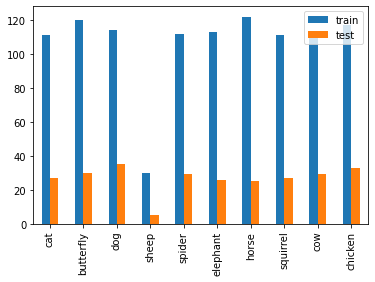

In [ ]:
# Show up the proportion of each observed category
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=labels).plot.bar()
plt.show()

#### 2.2: Data Normalizaiton

When using the image as-is and passing it through the neural network, the computation of high values can become more complicated. To reduce this, we can normalize the values to a range from 0 to 1.

This way, the numbers will be small and the calculation becomes easier and faster. Since the range of pixel values is 0 to 256, except for 0, the range is 255. therefore, dividing all values by 255 will convert them to a range of 0 to 1.

In [ ]:
x_train_norm = np.divide(dataset[0], 255)
x_test_norm = np.divide(dataset[0], 255)

print(x_test_norm[0, 0, 0, 0])

1.0


#### 2.3: Visualize Some Iamges

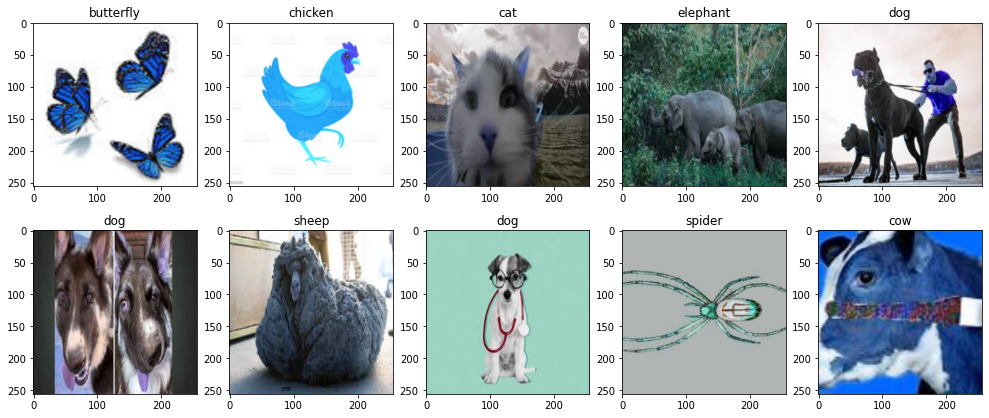

In [ ]:
def visualizeSomeImgs(data):
  labels_map = {0: "cat", 1: "butterfly", 2: "dog", 3: "sheep",
    4: "spider", 5: "elephant", 6: "horse", 7: "squirrel", 8: "cow", 9: "chicken",}

  figure = plt.figure(figsize=(17, 7))
  cols, rows = 5, 2
  for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.imshow(img)
  plt.show()

visualizeSomeImgs(dataset)

#### 2.4: Image Augmentataion

Deliberately introducing flaws/Adding noise in our dataset is critical to making our machine learning models more adaptable to the harsh realities they encounter in the real world. In other words, which could make the network is less able to memorize training samples because they are changing all the time, resulting in smaller network weights and a more robust network that has lower generalization error. In practice, there are various types of image defects, such as blur, poor contrast, noise, JPEG compression, and so on. Among them, blur is the most harmful.

According to this, we will consider three cases: compression, noise, and blurring. Like add the Salt and Pepper noise to some images in the dataset. And randomly put some irrelevant images to each category. It is synthetic label noise.

##### 2.4.1: Adding noise

In [ ]:
def gasuss_noise(image, mean=0, var=0.001):
    image = np.array(image / 255, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out * 255)

    return out

def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape, np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

def addnoise():
    animalList = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'spider', 'squirrel', 'sheep', 'horse']
    dataset_withNoise = []

    num_range = 75
    for animal in animalList:
      if animal == "sheep": 
        num_range = 15
      else:
        num_range = 75
        for i in range(0, num_range):
            img = cv2.imread(synthetic_folder_path + animal + "/" + str(i) + ".jpg", 1)
            img= sp_noise(img, 0.05)
            img = cv2.resize(img, IMAGE_SIZE)
            dataset_withNoise.append([img, animalList.index(animal)])
            cv2.imwrite(synthetic_folder_path + animal + "/" + str(i + 150) + ".jpg", img, [cv2.IMWRITE_JPEG_QUALITY, 20])

        print(animal, "Finished")
    return dataset_withNoise

In [ ]:
dataset_withNoise = addnoise()

butterfly Finished
cat Finished
chicken Finished
cow Finished
dog Finished
elephant Finished
spider Finished
squirrel Finished
horse Finished


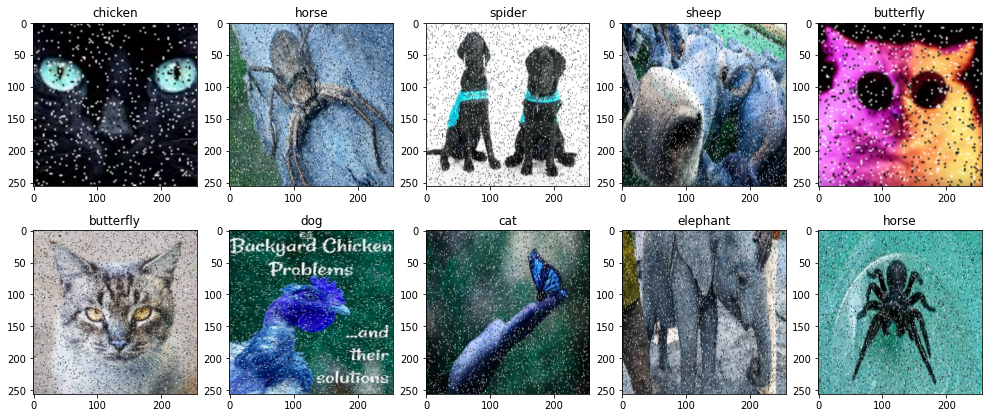

In [ ]:
visualizeSomeImgs(dataset_withNoise)

In [ ]:
# Check the image's shape
print(dataset[0][0].shape)
print(dataset_withNoise[0][0].shape)
print("Number of dataset:", len(dataset))
print("Number of dataset with noise:", len(dataset_withNoise))

(256, 256, 3)
(256, 256, 3)
Number of dataset: 1327
Number of dataset with noise: 675


In [ ]:
dataset_all = dataset_withNoise.copy()

for item in dataset:
  dataset_all.append(item)

print("Number of dataset with noise:", len(dataset_all))
#x_train_noise, x_test_noise, y_train_noise, y_test_nise = datasetSplit(dataset_withNoise)

Number of dataset with noise: 2002


##### 2.4.2: Bluring Image

When we blur an image, we make the color transition from one side of an edge in the image to another smooth rather than sudden. The effect is to average out rapid changes in pixel intensity. There are several different blurring functions in practice, so we will focus on just one here, the Gaussian blur.

So **kernel size** could be one of controlling parameters.

##### 2.4.3: Compressing

In [ ]:
def compress():
    animalList = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'spider', 'squirrel', 'sheep', 'horse']

    for animal in animalList:
        if not os.path.exists(animal): os.makedirs(animal)
        for i in range(1, 151):
            img = cv2.imread("./raw/" + animal + "/" + str(i) + ".jpg", 1)
            cv2.imwrite("./" + animal + "/" + str(i) + ".jpg", img, [cv2.IMWRITE_JPEG_QUALITY,20])
        print(animal, "Finished")

## P2: Model Ready and Trained

### Section 1. Model Building

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt

In [ ]:
splitDatasetFolder(synthetic_folder_path, train_folder_path, test_folder_path)

100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


In [ ]:
# Prepare the added noise dataset into Tensor format:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMAGE_SIZE[0]),
        transforms.RandomCrop(IMAGE_SIZE[0]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE[0]),
        transforms.CenterCrop(IMAGE_SIZE[0]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(splited_folder_path, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True)
              for x in ['train', 'test']}

train_loader = dataloaders['train']
test_loader = dataloaders['test']

In [ ]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64


#### 1.1: Convolutional Neural Network (CNN)

The convolutional neural network model is chosen here as a simple model with the following structure:

Conv2d (input channels=3, output channels = 15,kernel size = 5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Conv2d (input channels=15, output channels = 30,kernel size = 5)
$\rightarrow$
Dropout2d (p = 0.5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Linear(input dimension = 480, hidden units = 64)
$\rightarrow$
ReLU
$\rightarrow$
Dropout (p=0.5)
$\rightarrow$
Linear(input dimension = 64, hidden units = 10)
$\rightarrow$
LogSoftMax

In [ ]:
class NetWork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 15, 5)       
        self.pool = nn.MaxPool2d(2)    
        self.conv2 = nn.Conv2d(15, 30, 5)     
        self.drop = nn.Dropout2d(p=0.5)            
        self.liner1 = nn.Linear(111630, 64)            
        self.liner2 = nn.Linear(64, 10)
        
    def forward(self,x):
        # Size of input
        in_size = x.size(0)
        
        # step by step as following 
        out = self.conv1(x) 
        out = self.pool(out)
        out = F.relu(out)
        out = self.conv2(out) 
        out = self.drop(out)
        out = self.pool(out)
        out = F.relu(out)
        out = out.view(in_size,-1)
        out = self.liner1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.liner2(out)
        out = F.log_softmax(out,dim=1)
        
        return out

In [ ]:
model = NetWork()
print(model)

NetWork(
  (conv1): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (liner1): Linear(in_features=111630, out_features=64, bias=True)
  (liner2): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Sectin 2. Training & Evaluation

In [ ]:
trainLossRecords = []
testLossRecords = []
correctRateRecoeds = []

EPOCHS = 15

for epoch in range(1, EPOCHS + 1):

    model.train()
    
    # Extract data in order
    for batchId, (data, target) in enumerate(train_loader):
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fun(output, target)
        trainLossRecords.append(loss)
        loss.backward()
        optimizer.step()
        
        # print information
        if(batchId+1)%60 == 0:
            print('Train Epoch %-3d: [%-3d/%-3d ]\tLoss: %-7.5f'%(epoch, batchId * len(data), len(train_loader.dataset), loss.item()))
                
    
    # Start test
    
    # start evalution mode
    model.eval()
    
    # loss value all
    testLoss = 0
    
    # the number of correct
    correct = 0
    
    # no gradient update
    with torch.no_grad():
        for data, target in test_loader:      
            # get output
            output = model(data)
            
            # sum loss value
            loss = F.nll_loss(output, target, reduction='sum').item()
            testLoss += loss
            
            # predict
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    correctRate = 100. * correct / len(test_loader.dataset)
    testLoss /= len(test_loader.dataset)
    testLossRecords.append(testLoss)
    correctRateRecoeds.append(correctRate)
    print('Test Epoch %d : Average loss: %-7.5f, Accuracy: %-7d/%-7d = %-7.1f'%(epoch,testLoss, correct, len(test_loader.dataset),correctRate)+"%")

Test Epoch 1 : Average loss: 2.23713, Accuracy: 59     /403     = 14.6   %
Test Epoch 2 : Average loss: 2.20049, Accuracy: 68     /403     = 16.9   %
Test Epoch 3 : Average loss: 2.18038, Accuracy: 76     /403     = 18.9   %
Test Epoch 4 : Average loss: 2.14551, Accuracy: 92     /403     = 22.8   %
Test Epoch 5 : Average loss: 2.11934, Accuracy: 80     /403     = 19.9   %
Test Epoch 6 : Average loss: 2.10416, Accuracy: 95     /403     = 23.6   %
Test Epoch 7 : Average loss: 2.07520, Accuracy: 88     /403     = 21.8   %
Test Epoch 8 : Average loss: 2.03346, Accuracy: 119    /403     = 29.5   %
Test Epoch 9 : Average loss: 2.03686, Accuracy: 126    /403     = 31.3   %
Test Epoch 10 : Average loss: 2.00432, Accuracy: 120    /403     = 29.8   %
Test Epoch 11 : Average loss: 2.00125, Accuracy: 97     /403     = 24.1   %
Test Epoch 12 : Average loss: 1.95068, Accuracy: 139    /403     = 34.5   %
Test Epoch 13 : Average loss: 1.95192, Accuracy: 129    /403     = 32.0   %
Test Epoch 14 : Avera

In [ ]:
# Saving the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
def Display(data,xCol,title,xlabel,ylabel):
    plt.figure(figsize=(12,5))
    plt.plot(xCol,data,alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

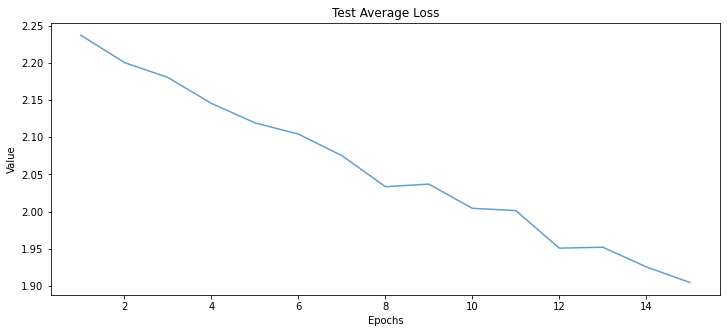

In [ ]:
Display(
    data=testLossRecords,
    xCol=range(1,len(testLossRecords)+1),
    title="Test Average Loss",
    xlabel="Epochs",
    ylabel="Value",
)

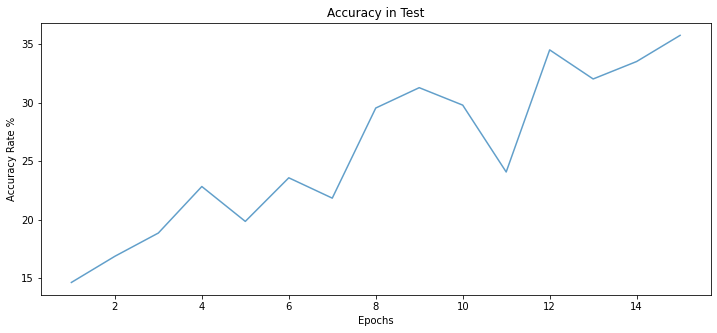

In [ ]:
Display(
    data=correctRateRecoeds,
    xCol=range(1,len(correctRateRecoeds)+1),
    title="Accuracy in Test",
    xlabel="Epochs",
    ylabel="Accuracy Rate %",
)

#Final Code

##Section 1. Model Building

###1.1: AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4)),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=(5, 5), padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*5*5, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_class)
        )

    def forward(self, x):
        x = self.features(x)
        print(x.size())
        x = x.view(x.size(0), 256 * 5 * 5)
        x = self.classifier(x)
        return x


model = AlexNet()


##Section 2. Training & Evaluation

##Section 3. Comparison and  Analysis